All data cleaned using ArcGIS. Pipeline:

1) Load raster and polygon datasets into ArcGIS - project each dataset into WGS1984 projection.

2) Convert all polygon data into raster data for data compatibility.

3) Identify locations at which we have response (carbon sequestration) data - use these points to sample and access all other variables.

4) Export table of sampled variables to csv - all further manipulation done in this Jupyter Notebook.

In [8]:
#loading necessary packages 
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.linear_model
import sklearn.decomposition
import sklearn.ensemble
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
#read in data
predictors = pd.read_csv('pnw_predictors.txt')
carbon = pd.read_csv('pnw_c.txt')
#combine predictor variables and response variable
full_data = pd.merge(predictors, carbon, how='left', left_on=['X','Y'], right_on=['X', 'Y'])
full_data.columns

Index(['OBJECTID_x', 'OR_random_Merge_x', 'X', 'Y', 'wc2_0_bio_10m_02',
       'wc2_0_bio_10m_03', 'wc2_0_bio_10m_04', 'wc2_0_bio_10m_05',
       'wc2_0_bio_10m_06', 'wc2_0_bio_10m_07', 'wc2_0_bio_10m_08',
       'wc2_0_bio_10m_09', 'wc2_0_bio_10m_10', 'wc2_0_bio_10m_11',
       'wc2_0_bio_10m_12', 'wc2_0_bio_10m_13', 'wc2_0_bio_10m_14',
       'wc2_0_bio_10m_15', 'wc2_0_bio_10m_16', 'wc2_0_bio_10m_17',
       'wc2_0_bio_10m_18', 'wc2_0_bio_10m_19',
       'Bare_ground_change_1982_2016__1_', 'Short_vegetation_change_1982_2016',
       'Tree_canopy_change_1982_2016', 'gt30w140n90', 'wc2_0_bio_10m_01',
       'OBJECTID_y', 'OR_random_Merge_y', 'raster_OR_c', 'raster_WA_c'],
      dtype='object')

In [10]:
or_sequestration = full_data[['raster_OR_c']].dropna()['raster_OR_c']
wa_sequestration = full_data[['raster_WA_c']].dropna()['raster_WA_c']
full_sequestration = list(or_sequestration)+list(wa_sequestration)
full_data['raster_OR_c'].fillna(full_data['raster_WA_c'], inplace=True)
cleaner = full_data.drop(['X', 'Y', 'OBJECTID_x', 'OR_random_Merge_x', 'OBJECTID_y', 'OR_random_Merge_y', 'raster_WA_c'], axis=1)
cleaner = cleaner.dropna()

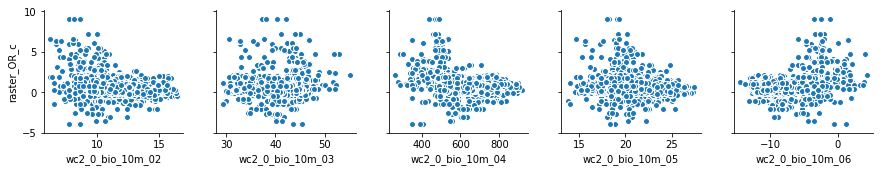

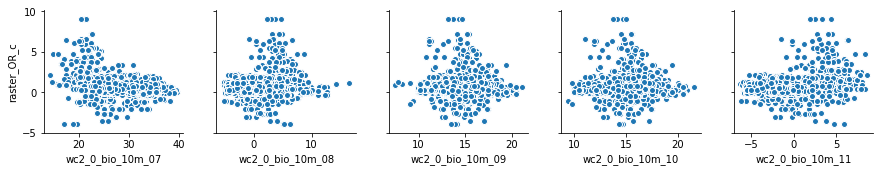

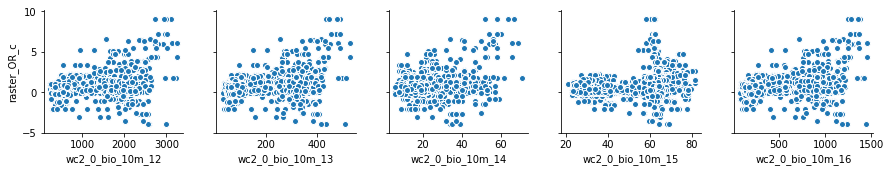

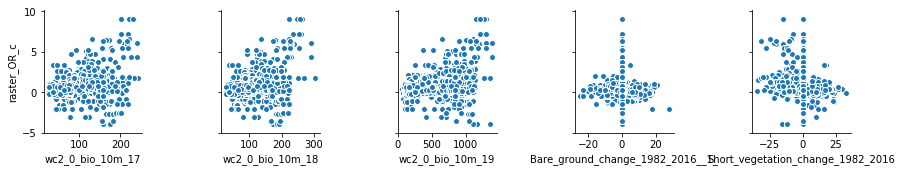

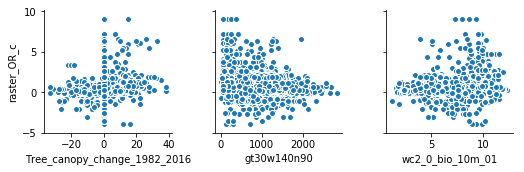

In [11]:
#data exploration
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[4:9])
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[9:14])
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[14:19])
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[19:24])
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[24:27])

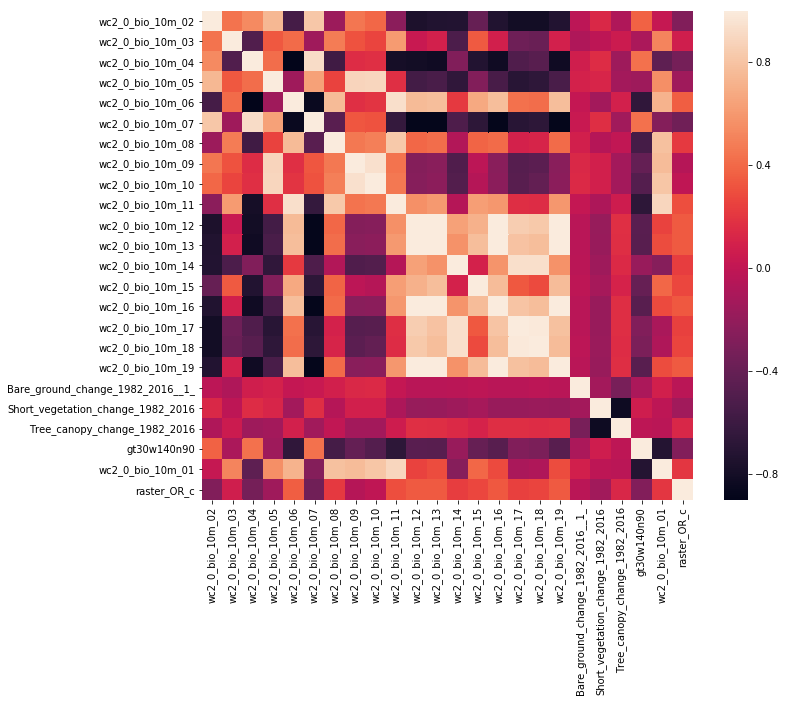

In [71]:
corr = cleaner.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr)

In [70]:
corr[['raster_OR_c']].sort_values('raster_OR_c')

,raster_OR_c
wc2_0_bio_10m_07,-0.354056
wc2_0_bio_10m_04,-0.334257
wc2_0_bio_10m_02,-0.283322
gt30w140n90,-0.272146
wc2_0_bio_10m_05,-0.146411
Short_vegetation_change_1982_2016,-0.142620
wc2_0_bio_10m_09,-0.051738
Bare_ground_change_1982_2016__1_,-0.025488
wc2_0_bio_10m_10,-0.006577
wc2_0_bio_10m_03,0.075223


In [72]:
from sklearn import preprocessing

In [34]:
X = cleaner.iloc[:, 0:23]
standard_X = pd.DataFrame(preprocessing.scale(X))
# cleaner['raster_OR_c']
standard_X['target'] = cleaner['raster_OR_c']
standard_X.columns = cleaner.columns
standard_X.head()

,wc2_0_bio_10m_02,wc2_0_bio_10m_03,wc2_0_bio_10m_04,wc2_0_bio_10m_05,wc2_0_bio_10m_06,wc2_0_bio_10m_07,wc2_0_bio_10m_08,wc2_0_bio_10m_09,wc2_0_bio_10m_10,wc2_0_bio_10m_11,...,wc2_0_bio_10m_16,wc2_0_bio_10m_17,wc2_0_bio_10m_18,wc2_0_bio_10m_19,Bare_ground_change_1982_2016__1_,Short_vegetation_change_1982_2016,Tree_canopy_change_1982_2016,gt30w140n90,wc2_0_bio_10m_01,raster_OR_c
0,0.402943,-0.052162,0.478296,-0.566094,-1.003294,0.486643,-1.038166,-0.964092,-1.172924,-1.177425,...,-0.859743,-0.575764,-0.714367,-0.847494,-0.011519,0.096445,-0.119862,1.051149,-1.432185,-0.062215
1,0.981048,-0.082440,0.986583,0.447605,-1.218835,1.182900,-0.945342,-0.147397,-0.325213,-1.136788,...,-0.952842,-0.807037,-0.930314,-0.941101,-0.011519,0.096445,-0.119862,0.942904,-0.908150,-0.062215
2,1.913955,0.026676,1.684685,2.234058,-1.284569,2.165188,-0.669905,1.359685,1.239101,-0.805737,...,-1.051418,-1.080358,-1.185523,-1.040558,-0.011519,0.096445,-0.119862,0.342636,0.166486,-0.062215
3,0.402943,-0.052162,0.478296,-0.566094,-1.003294,0.486643,-1.038166,-0.964092,-1.172924,-1.177425,...,-0.859743,-0.575764,-0.714367,-0.847494,-0.011519,0.096445,-0.119862,0.846467,-1.432185,-0.062215
4,0.402943,-0.052162,0.478296,-0.566094,-1.003294,0.486643,-1.038166,-0.964092,-1.172924,-1.177425,...,-0.859743,-0.575764,-0.714367,-0.847494,-0.011519,0.096445,-0.119862,1.062957,-1.432185,-0.062215


In [60]:
#First approach, with standardized data
pca = sklearn.decomposition.PCA(n_components=5)
pca.fit(cleaner.iloc[:,0:23])
small = pca.transform(standard_X.iloc[:,0:23])
train_pca = pd.DataFrame(small)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train_pca, cleaner.iloc[:,23], test_size=0.2)
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.14603996247258044

In [61]:
#this was a first approach, attempting to use all the data, without any intelligence in picking variables
pca = sklearn.decomposition.PCA(n_components=5)
pca.fit(cleaner.iloc[:,0:23])
small = pca.transform(cleaner.iloc[:,0:23])
train_pca = pd.DataFrame(small)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train_pca, cleaner.iloc[:,23], test_size=0.2)
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.12438413467711217

So just doing dimensionality reduction of the predictor variables didn't help...

In [62]:
X_train2, X_test2, y_train2, y_test2= sklearn.model_selection.train_test_split(
cleaner.loc[:,['Bare_ground_change_1982_2016__1_','Short_vegetation_change_1982_2016','Tree_canopy_change_1982_2016']], cleaner.iloc[:,23], test_size=0.2)

In [63]:
model = sklearn.linear_model.LinearRegression()
model.fit(X_train2, y_train2)
model.score(X_train2, y_train2)

0.02112784306841986

In [64]:
X_train2, X_test2, y_train2, y_test2= sklearn.model_selection.train_test_split(
standard_X.loc[:,['Bare_ground_change_1982_2016__1_','Short_vegetation_change_1982_2016','Tree_canopy_change_1982_2016']], cleaner.iloc[:,23], test_size=0.2)
model = sklearn.linear_model.LinearRegression()
model.fit(X_train2, y_train2)
model.score(X_train2, y_train2)

0.02495597102096825

and this ^ correlation from ground change data suggests the climate data is the part that matters for the small small correlation seen in the PCA above. All the 0 values for ground change data washes out any other relationship, it looks like - it seems reasonable, though, that areas of land that experienced a ground cover change would have a relationship between the magnitude of that change and carbon sequestration rates - eg higher sequestration where canopies increased - because these are non-equilibrium sequestration rates we're seeing!

In [78]:
#one more time - choosing features slightly more intelligently after looking at scatter plots
X_train3, X_test3, y_train3, y_test3= sklearn.model_selection.train_test_split(
cleaner.loc[:,['wc2_0_bio_10m_01',
       'wc2_0_bio_10m_17', 'wc2_0_bio_10m_12', 'wc2_0_bio_10m_11',
       'wc2_0_bio_10m_07', 'wc2_0_bio_10m_06']], cleaner.iloc[:,23], test_size=0.2)
model3 = sklearn.linear_model.LinearRegression()
model3.fit(X_train3, y_train3)
print('model 3 validation r^2: ', model3.score(X_train3, y_train3))
#the following was added after the fact, upon seeing correlation go up with random forest regressor
model3_5 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model3_5.fit(X_train3, y_train3)
print('model 3.5 validation r^2: ',model3_5.score(X_train3, y_train3))
print('model 3.5 test r^2: ', model3_5.score(X_test3, y_test3))

model 3 validation r^2:  0.13231912080720487
model 3.5 validation r^2:  0.8130917777948128
model 3.5 test r^2:  0.31289840987214235


No need to standardize data for the random forest model.

well that's a little better, but it's clear other layers are needed. Going to make a new dataset to work with that includes some more variables that could vary on the spatial scale we're forced to work with by virtue of the seq. data not being point data, but being polygon data that covers a larger area.

List of variables for this dataset:

bioclim variables 1,4,6,11,13,16 - ones that seem to have some relationship in the scatter plot exploration, but aren't redundant: Annual Mean Temperature, Temperature Seasonality, Min Temperature of Coldest Month, Mean Temperature of Coldest Quarter, Precipitation of Wettest Month, Precipitation of Wettest Quarter. Note that this somewhat matches up with an exploration of the covariance matrice, with 6, 11, 13, and 16 being within the top 6 most positively correlated variables with the target, and 4 being within the top 2 of the most negatively correlated. 

soil characteristics: cation exchange capacity, pH*10, and soil bulk density, all at 30cm (an arbitrary choice, but deep enough to not be very variable due to topsoil processes but shallow enough for a variety of tree sizes to respond to this)

existing carbon stock - more developed forest should have lower sequestration rates and higher existing carbon stock.

exclude topography (because response variable is reported as a mean over an area with variable topography) and bare ground change/tree canopy change/short vegetation change - a dream layer would be "time since disturbance", which would be created from the 1982-2011 data on tree cover, etc. see further description of this layer in "next steps"



Data processing:

merge oregon and washington soil rasters (ph, CEC, BD) using mosaic to new raster tool

add a "num_points" field to carbon sequestration (merged polygons) attribute table that's just the number 7

use Create Random Points tool - set constraining feature class to carbon sequestration polygons, use num_points field to determine how many will be sampled in each polygon.

use Polygon to Raster tool to turn oregon carbon stock, oregon sequestration, washington carbon stock, and washington sequestration to rasters.

Use mosaic to raster to turn the sequestration rasters into one, and stock rasters into one.

FINALLY use Sample tool to find raster values at all created random points.

Export table as .txt file


In [176]:
updated_data = pd.read_csv('fixedpnwround2.txt').replace(-9999, np.nan).drop('Rowid_', axis=1).dropna()
updated_data

,SAMPLE_POINTS,X,Y,CORRECTSEQ,COMBINED_C,COMBINED_PH,COMBINED_CEC,COMBINED_BD,WC2_0_BIO_10M_01,WC2_0_BIO_10M_04,WC2_0_BIO_10M_06,WC2_0_BIO_10M_11,WC2_0_BIO_10M_13,WC2_0_BIO_10M_16
0,0,911976.617356,5.357005e+06,2.029400,167.813904,58.965643,45.590278,255.000000,7.040217,799.130967,-10.968351,-2.694131,85.337638,240.268649
1,1,901817.075322,5.363050e+06,1.789343,158.315415,54.045296,43.888858,255.000000,6.328214,782.814812,-10.779201,-3.125324,83.965263,236.661452
2,2,918805.202873,5.369724e+06,2.029400,166.737509,62.911784,30.678458,255.000000,7.120946,808.225666,-11.248461,-2.795291,90.993851,258.906722
3,3,925121.402213,5.364111e+06,0.710281,99.616169,62.480930,33.984541,255.000000,7.106221,802.095926,-11.008685,-2.680838,94.153166,268.574089
4,4,906940.305528,5.361813e+06,2.029400,167.813904,58.638708,40.451616,255.000000,6.546063,787.948963,-10.826986,-3.001255,85.298647,240.266599
5,5,923194.379255,5.360839e+06,0.830374,99.259460,60.278140,34.636584,255.000000,7.230453,804.829520,-11.070569,-2.603661,91.762996,261.060821
6,6,908695.025174,5.368566e+06,2.029400,167.813904,57.000000,38.361477,255.000000,6.258049,782.755250,-10.806530,-3.211420,88.396264,250.332797
7,7,932480.046030,5.362512e+06,0.710281,99.259460,60.000000,48.729441,255.000000,6.864768,790.867193,-10.705518,-2.708903,99.388867,284.747798
8,8,915558.044959,5.383906e+06,0.710281,99.259460,58.000000,43.401705,255.000000,6.429720,786.482773,-11.026241,-3.110087,94.124048,268.541018
9,9,905884.243682,5.387936e+06,0.770816,99.259460,55.206737,38.345037,255.000000,5.668242,767.143103,-11.017449,-3.549550,91.886374,262.602256


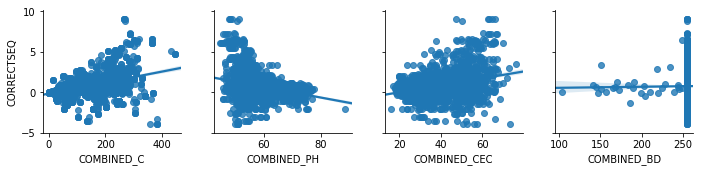

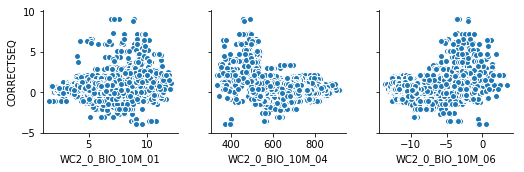

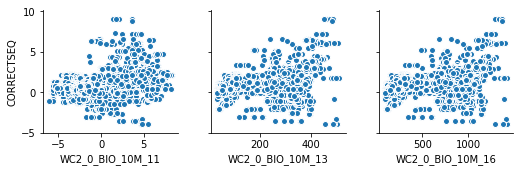

In [177]:
sns.pairplot(data=updated_data, x_vars=['COMBINED_C','COMBINED_PH', 'COMBINED_CEC', 'COMBINED_BD'],
             y_vars=['CORRECTSEQ'], kind='reg')
sns.pairplot(data=updated_data, x_vars=['WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06'], y_vars=['CORRECTSEQ'])
sns.pairplot(data=updated_data, x_vars=['WC2_0_BIO_10M_11',
       'WC2_0_BIO_10M_13', 'WC2_0_BIO_10M_16'], y_vars=['CORRECTSEQ'])

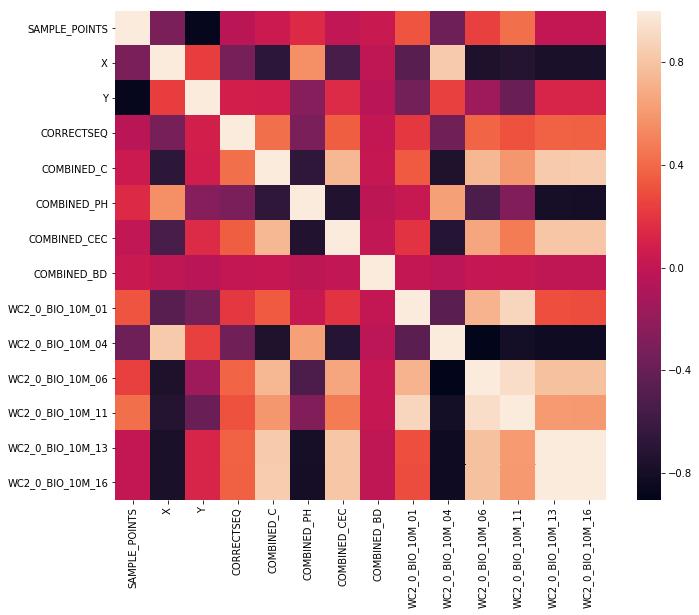

In [178]:
corr = updated_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr)

In [179]:
corr[['CORRECTSEQ']].sort_values('CORRECTSEQ')

,CORRECTSEQ
WC2_0_BIO_10M_04,-0.359209
X,-0.330338
COMBINED_PH,-0.313632
SAMPLE_POINTS,-0.030502
COMBINED_BD,0.006961
Y,0.079369
WC2_0_BIO_10M_01,0.208770
WC2_0_BIO_10M_11,0.313230
COMBINED_CEC,0.354086
WC2_0_BIO_10M_16,0.366330


In [180]:
updated_data

,SAMPLE_POINTS,X,Y,CORRECTSEQ,COMBINED_C,COMBINED_PH,COMBINED_CEC,COMBINED_BD,WC2_0_BIO_10M_01,WC2_0_BIO_10M_04,WC2_0_BIO_10M_06,WC2_0_BIO_10M_11,WC2_0_BIO_10M_13,WC2_0_BIO_10M_16
0,0,911976.617356,5.357005e+06,2.029400,167.813904,58.965643,45.590278,255.000000,7.040217,799.130967,-10.968351,-2.694131,85.337638,240.268649
1,1,901817.075322,5.363050e+06,1.789343,158.315415,54.045296,43.888858,255.000000,6.328214,782.814812,-10.779201,-3.125324,83.965263,236.661452
2,2,918805.202873,5.369724e+06,2.029400,166.737509,62.911784,30.678458,255.000000,7.120946,808.225666,-11.248461,-2.795291,90.993851,258.906722
3,3,925121.402213,5.364111e+06,0.710281,99.616169,62.480930,33.984541,255.000000,7.106221,802.095926,-11.008685,-2.680838,94.153166,268.574089
4,4,906940.305528,5.361813e+06,2.029400,167.813904,58.638708,40.451616,255.000000,6.546063,787.948963,-10.826986,-3.001255,85.298647,240.266599
5,5,923194.379255,5.360839e+06,0.830374,99.259460,60.278140,34.636584,255.000000,7.230453,804.829520,-11.070569,-2.603661,91.762996,261.060821
6,6,908695.025174,5.368566e+06,2.029400,167.813904,57.000000,38.361477,255.000000,6.258049,782.755250,-10.806530,-3.211420,88.396264,250.332797
7,7,932480.046030,5.362512e+06,0.710281,99.259460,60.000000,48.729441,255.000000,6.864768,790.867193,-10.705518,-2.708903,99.388867,284.747798
8,8,915558.044959,5.383906e+06,0.710281,99.259460,58.000000,43.401705,255.000000,6.429720,786.482773,-11.026241,-3.110087,94.124048,268.541018
9,9,905884.243682,5.387936e+06,0.770816,99.259460,55.206737,38.345037,255.000000,5.668242,767.143103,-11.017449,-3.549550,91.886374,262.602256


In [181]:
stand_update = preprocessing.scale(updated_data[[x for x in updated_data.columns if x != 'CORRECTSEQ']])
stand_update = pd.DataFrame(stand_update)
stand_update.columns = [x for x in updated_data.columns if x != 'CORRECTSEQ']
stand_update.index = updated_data.index
stand_update['CORRECTSEQ'] = updated_data['CORRECTSEQ']
stand_update['SAMPLE_POINTS'] = updated_data['SAMPLE_POINTS']
stand_update['X'] = updated_data['X'] #correcting
stand_update['Y'] = updated_data['Y']
stand_update

,SAMPLE_POINTS,X,Y,COMBINED_C,COMBINED_PH,COMBINED_CEC,COMBINED_BD,WC2_0_BIO_10M_01,WC2_0_BIO_10M_04,WC2_0_BIO_10M_06,WC2_0_BIO_10M_11,WC2_0_BIO_10M_13,WC2_0_BIO_10M_16,CORRECTSEQ
0,0,911976.617356,5.357005e+06,0.385880,0.056491,0.714672,0.086505,0.064593,1.372853,-0.778299,-0.705597,-0.668412,-0.673757,2.029400
1,1,901817.075322,5.363050e+06,0.274039,-0.701341,0.562715,0.086505,-0.289219,1.225253,-0.725898,-0.848800,-0.679458,-0.683914,1.789343
2,2,918805.202873,5.369724e+06,0.373206,0.664276,-0.617130,0.086505,0.104710,1.455126,-0.855899,-0.739193,-0.622885,-0.621279,2.029400
3,3,925121.402213,5.364111e+06,-0.417126,0.597915,-0.321858,0.086505,0.097392,1.399675,-0.789473,-0.701182,-0.597455,-0.594059,0.710281
4,4,906940.305528,5.361813e+06,0.385880,0.006136,0.255729,0.086505,-0.180964,1.271697,-0.739136,-0.807596,-0.668726,-0.673763,2.029400
5,5,923194.379255,5.360839e+06,-0.421326,0.258642,-0.263623,0.086505,0.159126,1.424404,-0.806617,-0.675551,-0.616694,-0.615213,0.830374
6,6,908695.025174,5.368566e+06,0.385880,-0.246258,0.069054,0.086505,-0.324086,1.224714,-0.733469,-0.877393,-0.643793,-0.645420,2.029400
7,7,932480.046030,5.362512e+06,-0.421326,0.215802,0.995037,0.086505,-0.022592,1.298097,-0.705485,-0.710503,-0.555313,-0.548519,0.710281
8,8,915558.044959,5.383906e+06,-0.421326,-0.092238,0.519207,0.086505,-0.238778,1.258434,-0.794337,-0.843740,-0.597690,-0.594152,0.710281
9,9,905884.243682,5.387936e+06,-0.421326,-0.522456,0.067586,0.086505,-0.617176,1.083482,-0.791901,-0.989689,-0.615701,-0.610873,0.770816


bulk density doesn't seem to matter that much, and we don't have full data on it, so I'm going to drop it from the model:

In [172]:
X_train4, X_test4, y_train4, y_test4= sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model4 = sklearn.linear_model.RidgeCV()
model4.fit(X_train4, y_train4)
model4.score(X_train4, y_train4)

0.23473755492766624

In [173]:
X_train4, X_test4, y_train4, y_test4= sklearn.model_selection.train_test_split(
stand_update.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model4 = sklearn.linear_model.RidgeCV()
model4.fit(X_train4, y_train4)
model4.score(X_train4, y_train4)

0.239194687599513

Although this is absolutely nowhere near the predictive power we'd like, it has improved a lot from previously, showing the importance of careful feature selection!


In [174]:
X_train5, X_test5, y_train5, y_test5= sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC', 'WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model5 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model5.fit(X_train5, y_train5)
print('training r^2: ', model5.score(X_train5, y_train5))
#first time the r^2 is high enough that i actually want to see validation accuracy!
print('validation r^2: ', model5.score(X_test5, y_test5))


training r^2:  0.9425989740984942
validation r^2:  0.7459069278735906


/home/austen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [186]:
# Last trials - splitting by geography and creating separate 
region1 = updated_data[updated_data['X']> 700000] #Arbitrary split on x >/<= 700000
region2 = updated_data[updated_data['X'] <= 700000]

In [193]:
X_train5_1, X_test5_1, y_train5_1, y_test5_1= sklearn.model_selection.train_test_split(
region1.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC', 'WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], region1.loc[:,['CORRECTSEQ']], test_size=0.2)
model5_1 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model5_1.fit(X_train5_1, y_train5_1)
print('training r^2: ', model5_1.score(X_train5_1, y_train5_1))
#first time the r^2 is high enough that i actually want to see validation accuracy!
print('validation r^2: ', model5_1.score(X_test5_1, y_test5_1))

training r^2:  0.9375586210177976
validation r^2:  0.7049654572337647


/home/austen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [194]:
X_train5_2, X_test5_2, y_train5_2, y_test5_2= sklearn.model_selection.train_test_split(
region2.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC', 'WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], region2.loc[:,['CORRECTSEQ']], test_size=0.2)
model5_2 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model5_2.fit(X_train5_2, y_train5_2)
print('training r^2: ', model5_2.score(X_train5_2, y_train5_2))
#first time the r^2 is high enough that i actually want to see validation accuracy!
print('validation r^2: ', model5_2.score(X_test5_2, y_test5_2))


training r^2:  0.9361891965863167
validation r^2:  0.6947274336199959


/home/austen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Not much difference between the two models (split of around 1000 data points in region1, 1800 in region 2). This could be because the data here is quite similar, even across the two datasets - the type of region does not differ extremely across the washington/oregon region, and thus the models are extremely similar.

In [260]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 10, 20, 30, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [5, 7, 10]
}

rf = sklearn.ensemble.RandomForestRegressor(random_state = 10)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [261]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    grid_search.fit(X_train5, y_train5) # Do grid search on the original test/train split with
#updated_data

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5 
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5 
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5 
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5, total=   0.2s
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5, t

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.3s
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=7 
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=Non

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.6s


[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=10 
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=Non

[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10 
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=7 
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_depth=Non

[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=7 
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=7, total=   0.0s
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.1s
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=7, total=   0.1s
[CV] bootstrap=Tru

[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=N

[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=10 
[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.1s
[CV]  bootstrap=True, max_depth=

[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=None

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=10, max_features

[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   11.7s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=10, max_features=a

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5, total=   0.0s
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=7 
[CV] bootstrap=True, max_depth=10, max_features=sq

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.1s
[CV]  bootstrap=True, max_depth=10, max_features

[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_sam

[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=10, max_features=l

[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10 
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=7 
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10, total=   0.1s
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=l

[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5, total=   0.2s
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=7 
[CV] bootstrap=True, max_depth=20, max_features=aut

[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10, total=   0.3s
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV] bootstrap=True, max_depth=20, max_features=au

[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_sampl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5 
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=s

[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=7 
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=7, total=   0.2s
[CV]  bootstrap=True, max_depth=20, max_features=

[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=l

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   30.5s


[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.2s
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=20, max_features=lo

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=10, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=10 
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=5, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=7, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=7 
[CV] bootstrap=True, max_depth=30, max_features=au

[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=a

[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samp

[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=30, max_features=s

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=10, total=   0.2s
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=7 
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=

[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=7 
[CV] bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=30,

[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV] bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=30, max_features=lo

[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=10, total=   0.4s
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=5, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=5, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=a

[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.3s
[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV] bootstrap=True, max_depth=50, max_features=a

[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=7, total=   0.2s
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=5 
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=5 
[CV] bootstrap=True, max_depth=50, max_features=sq

[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=10 
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.1s
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=sq

[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=7 
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=7, total=   0.2s
[CV]  bootstrap=True, max_depth=50, max_features=s

[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=5 
[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=7, total=   0.1s
[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=7 
[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=5, total=   0.1s
[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=50, max_features=log

[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.2s
[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.1s
[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=5 
[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7, total=   0.2s
[CV] bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=7 
[CV]  bootstrap=True, max_depth=50, max_features=l

[Parallel(n_jobs=-1)]: Done 1208 out of 1215 | elapsed:   57.4s remaining:    0.3s


[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.1s
[CV]  bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.2s


[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:   57.6s finished


In [262]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 10}

In [263]:
base_model = sklearn.ensemble.RandomForestRegressor(n_estimators =10, random_state = 10)
base_model.fit(X_train5, y_train5)
base_accuracy = base_model.score(X_test5, y_test5)
grid_accuracy = grid_search.best_estimator_.score(X_test5, y_test5)

/home/austen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [264]:
print(base_accuracy, grid_accuracy)

0.7720185054791983 0.7804549859506604


In [272]:
grid_search.best_estimator_.score(X_train5, y_train5)

0.9382087688848981

We tune the hyperparameters of the random forest regressor though cross-validated grid search. The final model is 1% better than the base model, although this minimal improvement is primarily due to a scarcity of data. 

In [40]:
X_train6, X_test6, y_train6, y_test6 = sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model6 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=10)
model6.fit(X_train6, y_train6)
print('training r^2: ', model6.score(X_train6, y_train6))
#well this isn't good - sticking to random forest classifier


training r^2:  0.438529257137261


/Users/nmushegian/anaconda3/envs/data-x/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


future datasets and how the model is going to get better:

1) worldwide data - more variability encompassed than the small differences we're trying to predict in just one forest type

2) point data rather than regional aggregate data - topography data (slope+aspect+elevation) will become useful then, as well as things like solar radiation

3) time since disturbance and other metrics of land use change - have to build this by looking at change in the hansen vegetation cover data

4) add solar radiation + windspeeds from worldclim

In [1]:
#here we have to use this Bad Classifier to predict carbon sequestration in a few places
#todo: get these variables for a new region, maybe southern canada 
# - can bound by regions for which we can find carbon stock, then sample from same .tifs
#maybe plot a min and max bound of a confidence interval as two layers?
#put that on the demo laptop - in ArcGIS - people can zoom around blah blah
#want to add MSE
#get "average uncertainty in predictions"